# Working with MODIS for Land Cover and LAI data

## Download MODIS data from AppEARS

MODIS provides satellite image data including ET, LAI and etc.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import rasterio
import fiona
import pandas
import cftime, datetime
import os
from matplotlib import pyplot as plt

import watershed_workflow
import watershed_workflow.ui
import watershed_workflow.sources.manager_modis_appeears
import watershed_workflow.land_cover_properties
import watershed_workflow.io
import watershed_workflow.timeseries
import watershed_workflow.datasets

watershed_workflow.ui.setup_logging(1,None)

In [3]:
watershed_shapefile = 'Coweeta/input_data/coweeta_basin.shp'
crs = watershed_workflow.crs.daymet_crs()

### Get the watershed

In [4]:
crs, watershed = watershed_workflow.get_split_form_shapes(watershed_shapefile, out_crs=crs)
watershed_workflow.split_hucs.simplify(watershed, 60)
logging.info(f'crs: {crs}')

bounds = watershed.exterior().bounds
print(bounds)
print(bounds[2] - bounds[0], bounds[3] - bounds[1])

2024-05-02 14:45:16,989 - root - INFO: 
2024-05-02 14:45:16,989 - root - INFO: Loading shapes
2024-05-02 14:45:16,989 - root - INFO: ------------------------------
2024-05-02 14:45:16,989 - root - INFO: Loading file: 'Coweeta/input_data/coweeta_basin.shp'
2024-05-02 14:45:16,999 - root - INFO: ... found 1 shapes
2024-05-02 14:45:17,000 - root - INFO: Converting to shapely
2024-05-02 14:45:17,000 - root - INFO:  ... done
2024-05-02 14:45:17,001 - root - INFO: Converting to requested CRS
2024-05-02 14:45:17,006 - root - INFO:  ... done
2024-05-02 14:45:17,007 - root - INFO: Removing holes on 1 polygons
2024-05-02 14:45:17,007 - root - INFO:   -- removed interior
2024-05-02 14:45:17,008 - root - INFO:   -- union
2024-05-02 14:45:17,008 - root - INFO: Parsing 1 components for holes
2024-05-02 14:45:17,008 - root - INFO:   -- complete
2024-05-02 14:45:17,009 - root - INFO: crs: +proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs


(1442135.5954880337, -650282.0481837074, 1447110.5975158159, -645090.2638397979)
4975.002027782146 5191.784343909472


### Download the data

In [5]:
source = watershed_workflow.sources.manager_modis_appeears.FileManagerMODISAppEEARS()

In [6]:
start_year = 2010
end_year = 2020

startdate = f"{start_year}-1-1"
enddate = f"{end_year+1}-1-1"

# note that AppEEARS typically takes a few minutes to prepare your data.  Therefore we return a task, which can be re-checked later.  
# So you could launch this call more-or-less immediately upon entering your workflow, continue the workflow, then call wait after
# all your other work is done.  Here we just immediately call wait, which checks every few minutes to see if AppEEARs is ready.
task = source.get_data(bounds, crs, startdate, enddate) 


2024-05-02 14:45:17,032 - root - INFO: ... searching for: /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LAI_01-01-2010_01-01-2021_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-02 14:45:17,033 - root - INFO: ... searching for: /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LULC_01-01-2010_01-01-2021_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-02 14:45:17,033 - root - INFO: ... reading LAI from /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LAI_01-01-2010_01-01-2021_35.0892x-83.4947_35.0124x-83.4076.nc
2024-05-02 14:45:17,045 - root - INFO: ... reading LULC from /home/ecoon/code/watershed_workflow/data/land_cover/MODIS/modis_LULC_01-01-2010_01-01-2021_35.0892x-83.4947_35.0124x-83.4076.nc


3652
3653


In [7]:
# note that occassionally the bundle is found, but then when we try to download we get a 404 error for the actual data.  In this case,
# simply try again -- usually the bundle thinks it is ready but the AWS server isn't updated yet or something...
if isinstance(task, watershed_workflow.sources.manager_modis_appeears.Task):
    data = source.wait(task)
else:
    data = task

In [8]:
for d in data:
    print(d, data[d].times[0])


LAI 2009-12-31 00:00:00
LULC 2010-01-01 00:00:00


Check for outliers in the data, and fix if needed.

In [9]:
# LAI extent
print('LAI:', data['LAI'].data.min(), data['LAI'].data.max())

# LULC extent
print('LULC:', data['LULC'].data.min(), data['LULC'].data.max())


LAI: 0.0 7.0
LULC: 4 8


## Compute time series of LAI

First, MODIS is "real" data, and so has leap year.  Our runs do not include leap year, so we first convert to a noleap calendar by dropping leap day data.

In [10]:
# times are stored as a dataset attribute -- loop over each dataset and remove leap day
for dset in data.collections:
    print(type(dset))
    print(dset.times)
    watershed_workflow.datasets.removeLeapDay(dset)

# note the calendar is now 'noleap'!
print(data['LAI'].times[0])

# need new start and end dates in the new calendar
startdate = cftime.datetime(start_year, 1, 1, calendar='noleap')
enddate = cftime.datetime(end_year, 12, 31, calendar='noleap')

<class 'watershed_workflow.datasets.Dataset'>
[cftime.DatetimeGregorian(2009, 12, 31, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2010, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2010, 1, 5, 0, 0, 0, 0, has_year_zero=False) ...
 cftime.DatetimeGregorian(2020, 12, 26, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2020, 12, 30, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2021, 1, 1, 0, 0, 0, 0, has_year_zero=False)]
<class 'watershed_workflow.datasets.Dataset'> <class 'str'> LAI
<class 'watershed_workflow.datasets.Dataset'>
[cftime.DatetimeGregorian(2010, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2011, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2012, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2013, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2014, 1, 1, 0, 0, 0, 0, has_year_zero=False)
 cftime.DatetimeGregorian(2015, 1, 1, 0, 0, 0, 0, ha

### Form the dynamic time-series.

The raw data is integrated in space by intersecting each LULC index with the LAI raster and summing over that mask.  This is done for each time of LAI observation to form a time series.

In [11]:
# compute the dynamic time series
lai_df = watershed_workflow.land_cover_properties.compute_time_series(data['LAI'], data['LULC'], polygon=watershed.exterior(), polygon_crs=crs)
lai_df

,time [datetime],MODIS Deciduous Broadleaf Forests LAI [-]
0,2009-12-31 00:00:00,0.547619
1,2010-01-01 00:00:00,0.547619
2,2010-01-05 00:00:00,0.593333
3,2010-01-09 00:00:00,0.578095
4,2010-01-13 00:00:00,0.640000
...,...,...
1007,2020-12-18 00:00:00,0.654286
1008,2020-12-22 00:00:00,0.490476
1009,2020-12-26 00:00:00,0.585714
1010,2020-12-30 00:00:00,0.620000


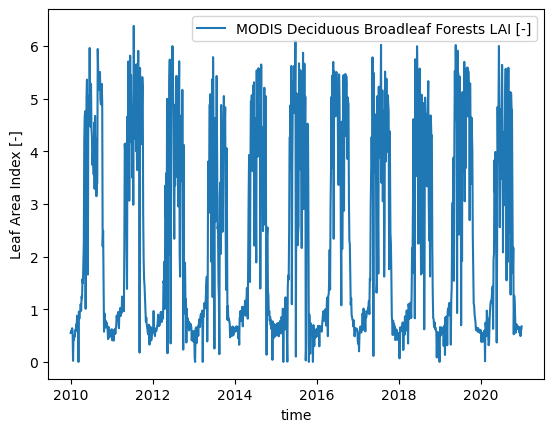

In [12]:
# plot the dynamic data
fig = plt.figure()
ax = fig.add_subplot(111)

date = np.array([datetime.datetime(t.year, t.month, t.day) for t in lai_df['time [datetime]']])
for column in lai_df:
    if column != 'time [datetime]':
        ax.plot(date, lai_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()


In [13]:
# write the dynamic data to disk
filename = os.path.join('Coweeta', 'output_data', f'modis_lai-{start_year}-{end_year}.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, lai_df, time0=startdate)

2024-05-02 14:45:17,247 - root - INFO: Writing HDF5 file: Coweeta/output_data/modis_lai-2010-2020.h5


### Form data for a typical year

In addition to the dynamic data, we need a typical year for cyclic steadystate spinup purposes.

In [14]:
# also compute a typical year of LAI
typical_df = watershed_workflow.timeseries.computeAverageYear(lai_df, output_nyears=2, start_year=2010, smooth=True)
typical_df

,time [datetime],MODIS Deciduous Broadleaf Forests LAI [-]
0,2000-01-01 00:00:00,0.529502
1,2000-01-02 00:00:00,0.528145
2,2000-01-03 00:00:00,0.526643
3,2000-01-04 00:00:00,0.525191
4,2000-01-05 00:00:00,0.523823
...,...,...
725,2001-12-27 00:00:00,0.532976
726,2001-12-28 00:00:00,0.532997
727,2001-12-29 00:00:00,0.532607
728,2001-12-30 00:00:00,0.531671


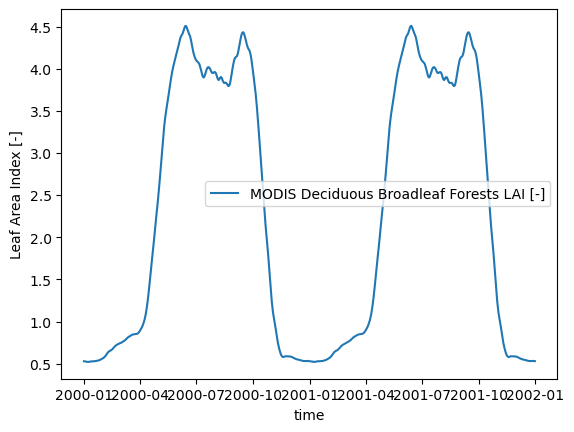

In [15]:
# plot the dynamic data
fig = plt.figure()
ax = fig.add_subplot(111)

time = np.array([datetime.datetime(*t.timetuple()[0:6]) for t in typical_df['time [datetime]']])
for column in typical_df:
    if column != 'time [datetime]':
        ax.plot(time, typical_df[column], label=column)
ax.set_ylabel('Leaf Area Index [-]')
ax.set_xlabel('time')
ax.legend()
plt.show()

In [16]:
# write the typical year to disk
filename = os.path.join('Coweeta', 'output_data', f'modis_lai-typical.h5')
watershed_workflow.io.write_timeseries_to_hdf5(filename, typical_df, time0=typical_df['time [datetime]'][0])

2024-05-02 14:45:17,501 - root - INFO: Writing HDF5 file: Coweeta/output_data/modis_lai-typical.h5


## Map MODIS landcover to NLCD landcover

We use NLCD for its high resolution, but need LAI from MODIS.  Therefore we will get NLCD on the domain, and form the "crosswalk" between NLCD and MODIS.

In [17]:
# get the NLCD data on the polygon
nlcd = watershed_workflow.source_list.FileManagerRaster('Coweeta/input_data/land_cover/land_cover.tif')
nlcd_profile, nlcd_raster = watershed_workflow.get_raster_on_shape(nlcd, watershed.exterior(), crs)

2024-05-02 14:45:17,511 - root - INFO: 
2024-05-02 14:45:17,511 - root - INFO: Loading Raster
2024-05-02 14:45:17,511 - root - INFO: ------------------------------
2024-05-02 14:45:17,512 - root - INFO: Collecting raster
2024-05-02 14:45:17,523 - root - INFO: bounds in my_crs: (1129295.2795605154, 1404623.589663599, 1134445.5249579642, 1410000.8473879488)
2024-05-02 14:45:17,523 - root - INFO: ... got raster of shape: (180, 173)
2024-05-02 14:45:17,526 - root - INFO: ... got raster bounds: (1129275.0, 1410015.0, 1134465.0, 1404615.0)


2024-05-02 14:45:17,560 - root - INFO: BOUNDS: (1129275.0, 1404615.0, 1134465.0, 1410015.0)
/home/ecoon/code/miniforge3/envs/watershed-workflow-master-20240429/lib/python3.10/site-packages/pyproj/crs/crs.py:1286: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
2024-05-02 14:45:17,630 - root - INFO: BOUNDS: (-83.4937499925202, 35.01041666353025, -83.40624999252803, 35.089583330189825)


[4, 8] ['Deciduous Broadleaf Forests', 'Woody Savannas']
(0.9137254901960784, 1.0, 0.7450980392156863, 1.0)
(0.9137254901960784, 1.0, 0.7450980392156863, 1.0)


Text(0.5, 1.0, 'MODIS LULC Index')

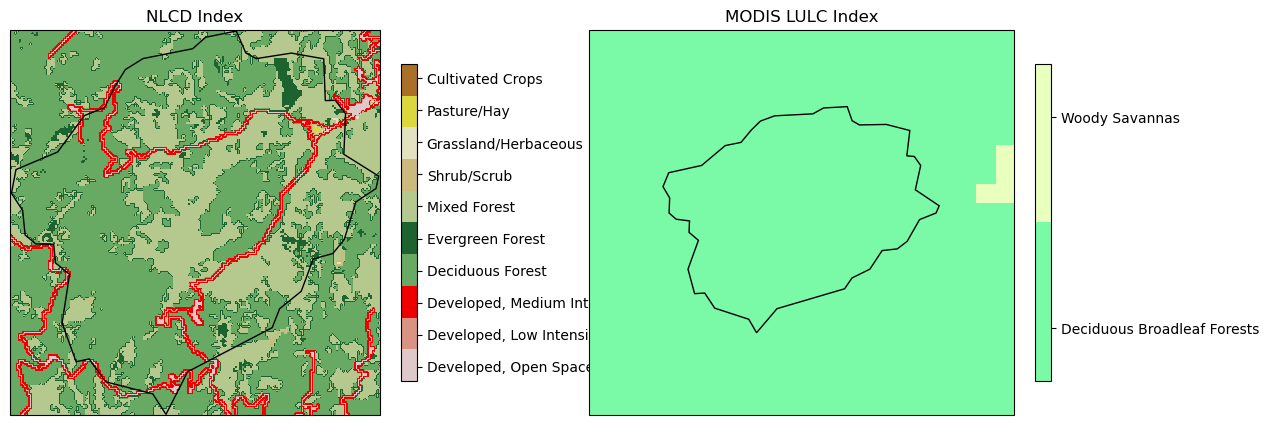

In [18]:
# plot NLCD and MODIS land use
axs = []
fig, a0 = watershed_workflow.plot.get_ax(nlcd_profile['crs'], nrow=1, ncol=2, index=1, figsize=(15,5))
axs.append(a0) 

# plot the image
# -- get the NLCD colormap which uses official NLCD colors and labels
nlcd_indices, nlcd_cmap, nlcd_norm, nlcd_ticks, nlcd_labels = \
            watershed_workflow.colors.generate_nlcd_colormap(np.unique(nlcd_raster))

im = watershed_workflow.plot.raster(nlcd_profile, nlcd_raster, ax=axs[0], cmap=nlcd_cmap, norm=nlcd_norm)
watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, nlcd_profile['crs']), nlcd_profile['crs'], 'k', axs[0])
watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(nlcd_raster)), cmap=nlcd_cmap, labels=nlcd_labels, ax=axs[0]) 
axs[0].set_title("NLCD Index")


modis_raster = data['LULC'].data[-1]
modis_profile = data['LULC'].profile

a1 = watershed_workflow.plot.get_ax(modis_profile['crs'], nrow=1, ncol=2, index=2, fig=fig)
axs.append(a1)

modis_indices, modis_cmap, modis_norm, modis_ticks, modis_labels = \
            watershed_workflow.colors.generate_modis_colormap(np.unique(modis_raster))
print(modis_indices, modis_labels)
print(modis_cmap(8))
print(modis_cmap(4))
im = watershed_workflow.plot.raster(modis_profile, modis_raster, ax=axs[1], cmap=modis_cmap, norm=modis_norm)
watershed_workflow.plot.shply(watershed_workflow.warp.shply(watershed.exterior(), crs, modis_profile['crs']), modis_profile['crs'], 'k', axs[1])
watershed_workflow.colors.colorbar_index(ncolors=len(np.unique(modis_raster)), cmap=modis_cmap, labels=modis_labels, ax=axs[1]) 
axs[1].set_title("MODIS LULC Index")


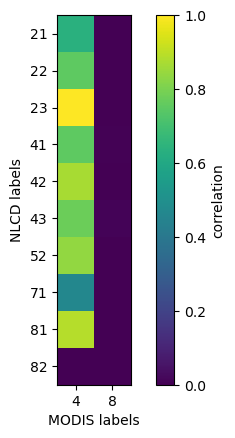

{21: 4, 22: 4, 23: 4, 41: 4, 42: 4, 43: 4, 52: 4, 71: 4, 81: 4, 82: 4}


In [19]:
# form the crosswalk and plot a correlation matrix
#
# note that for Coweeta, it is fairly simple because MODIS thinks that everthing is 4 (Broad leaf deciduous)
crosswalk = watershed_workflow.land_cover_properties.compute_crosswalk_correlation(data['LULC'].profile, data['LULC'].data[-1],
                                                                                   nlcd_profile, nlcd_raster)

print(crosswalk)